In [1]:
#استيراد المكتبات المطلوبة
import zipfile
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
import multiprocessing
from PIL import ImageEnhance
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-05-11 22:50:44.760983: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-11 22:50:45.914485: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/abdennacer/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
#تحديد مسار العمل
base_path = '/home/abdennacer/Documents/GitHub/data/traffic/GTSRB'
# تحديد مسار الملف المضغوط
zip_path = base_path + '/dataset-german-traffic-sign.zip'

# تحديد مسار الاستخراج
extract_path = base_path + '/dataset'

# إنشاء دليل لتخزين الملفات المستخرجة
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

# فك ضغط الملف
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"تم فك الضغط في المسار: {extract_path}")

In [3]:

#استخدام  وحدة معالجة الرسوميات في حالة توفرها
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    device_name = '/device:GPU:0'
    print("يتم استخدام  وحدة معالجة الرسوميات")
else:
    device_name = '/device:CPU:0'
    print(" وحدة معالجة الرسوميات غير متوفرة، سيتم استخدام وحدة المعالجة المركزية")
    tf.config.threading.set_intra_op_parallelism_threads(multiprocessing.cpu_count())
    tf.config.threading.set_inter_op_parallelism_threads(multiprocessing.cpu_count())


GPU is not available. Using CPU.


2024-05-08 19:54:33.830373: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-08 19:54:33.842481: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
def adjust_contrast(x):
    # تغيير تباين الصورة بشكل عشوائي
    factor = np.random.uniform(0.95, 1.05)  # عامل التباين العشوائي
    enhancer = ImageEnhance.Contrast(Image.fromarray(np.uint8(x)))  # تحسين الصورة
    x = enhancer.enhance(factor)
    return np.array(x)

In [5]:
# إعداد زيادة البيانات
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.15,
    height_shift_range=0.15,
    brightness_range=[0.95,1.05],  # ضبط السطوع
    preprocessing_function=adjust_contrast,  # استخدم وظيفة التباين المخصصة
    horizontal_flip=False,
    vertical_flip=False
)

In [6]:
# تحميل البيانات
data = []
labels = []
classes = 43
base_path = base_path + '/dataset'
for i in range(classes):
    path = os.path.join(base_path, 'Train', str(i))
    images = os.listdir(path)
    for a in images:
        try:
            image_path = os.path.join(path, a)
            image = Image.open(image_path)
            image = image.resize((30,30))
            image = np.array(image)
            data.append(image)
            labels.append(i)
        except Exception as e:
            print(f"هناك خطأ في تحميل الصور: {image_path}, {e}")

data = np.array(data)
labels = np.array(labels)
print(f"شكل البيانات: {data.shape}, شكل التسميات: {labels.shape}")


Data shape: (39209, 30, 30, 3), Labels shape: (39209,)


In [7]:

# تقسيم البيانات
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, 43)
y_test_encoded = to_categorical(y_test, 43)

In [8]:

# بناء وتدريب النموذج
with tf.device(device_name):
    model = Sequential([
        Conv2D(32, (5, 5), activation='relu', input_shape=X_train.shape[1:], kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(32, (5, 5), activation='relu', kernel_regularizer=l2(0.001)),
        MaxPool2D(2, 2),
        Dropout(0.25),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        MaxPool2D(2, 2),
        Dropout(0.25),
        BatchNormalization(),
        Flatten(),
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        BatchNormalization(),
        Dense(43, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    # التوقف المبكر لتجنب الإفراط في التلقين
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(datagen.flow(X_train, y_train, batch_size=100), epochs=1000, validation_data=(X_test, y_test_encoded), callbacks=[early_stopping])


/home/abdennacer/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 22, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 11, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 9, 9, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 3, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,787 (952.29 KB)

 Trainable params: 243,019 (949.29 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/1000


/home/abdennacer/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


314/314 ━━━━━━━━━━━━━━━━━━━━ 91s 281ms/step - accuracy: 0.1799 - loss: 3.7660 - val_accuracy: 0.5546 - val_loss: 1.8875
Epoch 2/1000
314/314 ━━━━━━━━━━━━━━━━━━━━ 85s 271ms/step - accuracy: 0.5918 - loss: 1.7609 - val_accuracy: 0.8558 - val_loss: 0.8755
Epoch 3/1000
314/314 ━━━━━━━━━━━━━━━━━━━━ 84s 267ms/step - accuracy: 0.8081 - loss: 1.0153 - val_accuracy: 0.9547 - val_loss: 0.5068
Epoch 4/1000
314/314 ━━━━━━━━━━━━━━━━━━━━ 68s 216ms/step - accuracy: 0.8830 - loss: 0.7162 - val_accuracy: 0.9774 - val_loss: 0.3939
Epoch 5/1000
314/314 ━━━━━━━━━━━━━━━━━━━━ 87s 277ms/step - accuracy: 0.9209 - loss: 0.5605 - val_accuracy: 0.9894 - val_loss: 0.3274
Epoch 6/1000
314/314 ━━━━━━━━━━━━━━━━━━━━ 104s 332ms/step - accuracy: 0.9372 - loss: 0.4821 - val_accuracy: 0.9867 - val_loss: 0.3101
Epoch 7/1000
314/314 ━━━━━━━━━━━━━━━━━━━━ 87s 277ms/step - accuracy: 0.9481 - loss: 0.4361 - val_accuracy: 0.9894 - val_loss: 0.2881
Epoch 8/1000
314/314 ━━━━━━━━━━━━━━━━━━━━ 98s 313ms/step - accuracy: 0.9581 - los

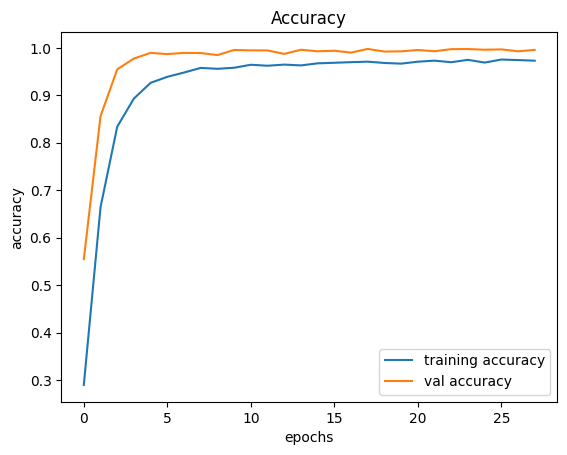

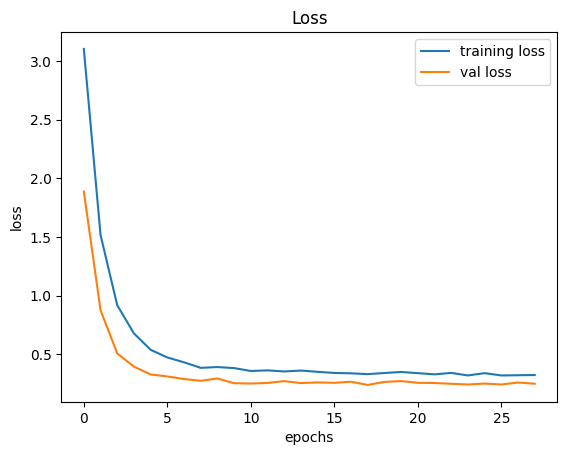

In [9]:

# عرض الدقة والانحدار
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


In [10]:
# اختبار النموذج
with tf.device(device_name):
    test_csv = pd.read_csv(os.path.join(base_path, 'Test.csv'))
    test_labels = test_csv["ClassId"].values
    test_imgs = test_csv["Path"].values
    data = [np.array(Image.open(os.path.join(base_path, img)).resize([30, 30])) for img in test_imgs]
    X_test = np.array(data)
    predictions = model.predict(X_test)
    predicted_classes = np.argmax(predictions, axis=-1)

print("اختبار الدقة:", accuracy_score(test_labels, predicted_classes))

395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Test accuracy: 0.9779097387173397


In [11]:
# تخزين النموذج
model.save(base_path + '/models/traffic_classifierDG1.h5')

In [ ]:
# استخلاص نسخة خفيفة، للإستخدام في راسبيري أو أجهزة صغيرة مشابهة
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

with open('modelDG1.tflite', 'wb') as f:
    f.write(tflite_model)

print("تم الحفظ بنجاح")